# Machine learning - An introduction of applications

## Diep Nguyen, Ph.D. 
### University of Engineering and Technology
### Vietnam National University, Hanoi

Mail-to: ngocdiep at vnu.edu.vn

Class: INT3405

Date: 15/10/2019

Period 3-5, 211-GD3

In [1]:
!python --version

Python 3.6.8 :: Anaconda, Inc.


# Collaborative Filtering

## Movie ranking data

In [2]:
# A dictionary of movie critics and their ratings of a small
# set of movies
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}


In [3]:
# let's have a better view of the data

# library to handle table-like data structures
import pandas as pd

df = pd.DataFrame.from_dict(critics, orient='index')
df

,Lady in the Water,Snakes on a Plane,Just My Luck,Superman Returns,"You, Me and Dupree",The Night Listener
Lisa Rose,2.5,3.5,3.0,3.5,2.5,3.0
Gene Seymour,3.0,3.5,1.5,5.0,3.5,3.0
Michael Phillips,2.5,3.0,NaN,3.5,NaN,4.0
Mick LaSalle,3.0,4.0,2.0,3.0,2.0,3.0
Jack Matthews,3.0,4.0,NaN,5.0,3.5,3.0
Claudia Puig,NaN,3.5,3.0,4.0,2.5,4.5
Toby,NaN,4.5,NaN,4.0,1.0,NaN


## Finding similar users

In [4]:
# euclidean distance between two vectors
def euclidean_distance(p, q):
    from math import sqrt
    sum_pow = sum([pow(p[i] - q[i], 2) for i in range(len(p))])
    return sqrt(sum_pow)

toby = (1.0, 4.5)
rose = (2.5, 3.5)
puig = (2.5, 3.5)
rose_toby = euclidean_distance(rose, toby)
rose_puig = euclidean_distance(rose, puig)

print("distance from rose to toby: ", rose_toby)
print("distance from rose to puig: ", rose_puig)

distance from rose to toby:  1.8027756377319946
distance from rose to puig:  0.0


In [5]:
# we want a function that returns higher values for those are similar
def similarity(p, q):
    dist = euclidean_distance(p, q)
    return 1/(1 + dist) # why 1+?


In [6]:
# calculate how much similar
rose_toby = similarity(rose, toby)
rose_puig = similarity(rose, puig)

print("similarity between rose and toby: ", rose_toby)
print("similarity between rose and puig: ", rose_puig)

similarity between rose and toby:  0.3567891723253309
similarity between rose and puig:  1.0


In [7]:
# Returns the best matches for person from the prefs dictionary. 
# Number of results and similarity function are optional params.

def sim_euclidean(prefs, person1, person2):
    #get the list of shared_items
    si = {}
    for item in prefs[person1]: 
        if item in prefs[person2]: si[item]=1
    
    # if they have no ratings in common, return 0
    if len(si)==0: return 0

    # Add up the squares of all the differences
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2) 
                      for item in prefs[person1] if item in prefs[person2]])

    return 1/(1+sum_of_squares)

def topMatches(prefs,person,n=5,similarity=sim_euclidean):
    scores=[(similarity(prefs,person,other),other) 
                  for other in prefs if other!=person]
    
    # Sort the list so the highest scores appear at the top
    scores.sort()
    scores.reverse()
    return scores[0:n]

In [8]:
topMatches(critics, "Toby")

[(0.3076923076923077, 'Mick LaSalle'),
 (0.2857142857142857, 'Michael Phillips'),
 (0.23529411764705882, 'Claudia Puig'),
 (0.2222222222222222, 'Lisa Rose'),
 (0.11764705882352941, 'Jack Matthews')]

In [9]:
topMatches(critics, "Lisa Rose")

[(0.4444444444444444, 'Michael Phillips'),
 (0.3333333333333333, 'Mick LaSalle'),
 (0.2857142857142857, 'Claudia Puig'),
 (0.2222222222222222, 'Toby'),
 (0.21052631578947367, 'Jack Matthews')]

## Recommending items

Problem statement: Recommend products for a given person

In [10]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,similarity=sim_euclidean):
    totals={}
    simSums={}
    for other in prefs:
        # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
        # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:

          # only score movies I haven't seen yet
          if item not in prefs[person] or prefs[person][item]==0:
            # Similarity * Score
            totals.setdefault(item,0)
            totals[item]+=prefs[other][item]*sim
            # Sum of similarities
            simSums.setdefault(item,0)
            simSums[item]+=sim

    # Create the normalized list
    rankings=[(total/simSums[item],item) for item,total in totals.items()]
    
    # Return the sorted list
    rankings.sort()
    rankings.reverse()
    return rankings

In [11]:
#get recommendation movies for Toby
getRecommendations(critics, "Toby")

[(3.5002478401415877, 'The Night Listener'),
 (2.7561242939959363, 'Lady in the Water'),
 (2.461988486074374, 'Just My Luck')]

## Matching products

Problem statement: Find which products are similar to each other

In [12]:
#just need to flip item and person
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})

            # Flip item and person
            result[item][person]=prefs[person][item]
    return result


In [13]:
movies = transformPrefs(critics)

In [14]:
pd.DataFrame.from_dict(movies, orient='index')

,Lisa Rose,Gene Seymour,Michael Phillips,Mick LaSalle,Jack Matthews,Claudia Puig,Toby
Lady in the Water,2.5,3.0,2.5,3.0,3.0,NaN,NaN
Snakes on a Plane,3.5,3.5,3.0,4.0,4.0,3.5,4.5
Just My Luck,3.0,1.5,NaN,2.0,NaN,3.0,NaN
Superman Returns,3.5,5.0,3.5,3.0,5.0,4.0,4.0
"You, Me and Dupree",2.5,3.5,NaN,2.0,3.5,2.5,1.0
The Night Listener,3.0,3.0,4.0,3.0,3.0,4.5,NaN


In [15]:
topMatches(movies, "Superman Returns")

[(0.16666666666666666, 'Snakes on a Plane'),
 (0.10256410256410256, 'The Night Listener'),
 (0.09090909090909091, 'Lady in the Water'),
 (0.06451612903225806, 'Just My Luck'),
 (0.05333333333333334, 'You, Me and Dupree')]

In [16]:
#try different distance
# returns the Pearson correlation coefficient
def sim_pearson(prefs,p1,p2):
    from math import sqrt
    # Get the list of mutually rated items
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1

    # if they are no ratings in common, return 0
    if len(si)==0: return 0

    # Sum calculations
    n=len(si)

    # Sums of all the preferences
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])

    # Sums of the squares
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])

    # Sum of the products
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])

    # Calculate r (Pearson score)
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=num/den

    return r

In [17]:
topMatches(movies, "Superman Returns", similarity=sim_pearson)

[(0.6579516949597695, 'You, Me and Dupree'),
 (0.4879500364742689, 'Lady in the Water'),
 (0.11180339887498941, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

### Item-based Collaborative Filtering

Precompute the similarity database between all items to each item

In [18]:
def calculateSimilarItems(prefs,n=10, similarity=sim_euclidean):
    # Create a dictionary of items showing which other items they
    # are most similar to.
    result={}
    # Invert the preference matrix to be item-centric
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
        # Status updates for large datasets
        c+=1
        if c%100==0:
            print("%d / %d" % (c,len(itemPrefs)))
        # Find the most similar items to this one
        scores=topMatches(itemPrefs,item,n=n,similarity=similarity)
        result[item]=scores
    return result

In [19]:
itemsim = calculateSimilarItems(critics)
itemsim

{'Lady in the Water': [(0.4, 'You, Me and Dupree'),
  (0.2857142857142857, 'The Night Listener'),
  (0.2222222222222222, 'Snakes on a Plane'),
  (0.2222222222222222, 'Just My Luck'),
  (0.09090909090909091, 'Superman Returns')],
 'Snakes on a Plane': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'The Night Listener'),
  (0.16666666666666666, 'Superman Returns'),
  (0.10526315789473684, 'Just My Luck'),
  (0.05128205128205128, 'You, Me and Dupree')],
 'Just My Luck': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'You, Me and Dupree'),
  (0.15384615384615385, 'The Night Listener'),
  (0.10526315789473684, 'Snakes on a Plane'),
  (0.06451612903225806, 'Superman Returns')],
 'Superman Returns': [(0.16666666666666666, 'Snakes on a Plane'),
  (0.10256410256410256, 'The Night Listener'),
  (0.09090909090909091, 'Lady in the Water'),
  (0.06451612903225806, 'Just My Luck'),
  (0.05333333333333334, 'You, Me and Dupree')],
 'You, Me and Dupree': [(0.4,

In [21]:
#get recommendation items
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}
    # Loop over items rated by this user
    for (item,rating) in userRatings.items( ):

        # Loop over items similar to this one
        for (similarity,item2) in itemMatch[item]:

            # Ignore if this user has already rated this item
            if item2 in userRatings: continue
            # Weighted sum of rating times similarity
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
            # Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity

    # Divide each total score by total weighting to get an average
    rankings=[(score/totalSim[item],item) for item,score in scores.items( )]

    # Return the rankings from highest to lowest
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [22]:
#get recommendation to Toby using item-based filtering
getRecommendedItems(critics, itemsim, 'Toby')

[(3.182634730538922, 'The Night Listener'),
 (2.5983318700614575, 'Just My Luck'),
 (2.4730878186968837, 'Lady in the Water')]

# Data clustering

In [23]:
#preferences data
def readfile(filename):
    with open(filename, 'r') as f:
        lines=[line for line in f]
    
    # First line is the column titles
    colnames=lines[0].strip().split('\t')[1:]
    rownames=[]
    data=[]
    for line in lines[1:]:
        p=line.strip().split('\t')
        # First column in each row is the rowname
        rownames.append(p[0])
        # The data for this row is the remainder of the row
        data.append([float(x) for x in p[1:]])
    return rownames,colnames,data

In [24]:
rownames, colnames, data = readfile("zebo.txt")

In [25]:
import numpy as np
x = np.array(data)

In [26]:
x.shape

(35, 500)

In [27]:
rownames

['bike',
 'clothes',
 'dvd player',
 'phone',
 'cell phone',
 'dog',
 'xbox 360',
 'boyfriend',
 'watch',
 'laptop',
 'love',
 'car',
 'shoes',
 'jeans',
 'money',
 'ps3',
 'psp',
 'puppy',
 'house and lot',
 'tv',
 'family',
 'food',
 'house',
 'horse',
 'mobile',
 'cds',
 'playstation 3',
 'mp3 player',
 'ipod',
 'digital camera',
 'mansion',
 'cellphone',
 'computer',
 'job',
 'friends']

In [28]:
def tanimoto(v1,v2):
    '''
    Tanimoto coefficient = ratio of the intersection set (only the items that are in both sets)
    to the union set (all the items in either set)
    '''
    c1,c2,shr=0,0,0
    
    for i in range(len(v1)):
        if v1[i]!=0: c1+=1 # in v1
        if v2[i]!=0: c2+=1 # in v2
        if v1[i]!=0 and v2[i]!=0: shr+=1 # in both
    
    return 1.0-(float(shr)/(c1+c2-shr))


In [32]:

class bicluster:
    def __init__(self,vec,left=None,right=None,distance=0.0,id=None):
        self.left=left
        self.right=right
        self.vec=vec
        self.id=id
        self.distance=distance

def hcluster(rows,distance=tanimoto):
    distances={}
    currentclustid=-1

    # Clusters are initially just the rows
    clust=[bicluster(rows[i],id=i) for i in range(len(rows))]

    while len(clust)>1:
        lowestpair=(0,1)
        closest=distance(clust[0].vec,clust[1].vec)

        # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i+1,len(clust)):
                # distances is the cache of distance calculations
                if (clust[i].id,clust[j].id) not in distances: 
                    distances[(clust[i].id,clust[j].id)]=distance(clust[i].vec,clust[j].vec)

                d=distances[(clust[i].id,clust[j].id)]

                if d<closest:
                    closest=d
                    lowestpair=(i,j)

        # calculate the average of the two clusters
        mergevec=[
        (clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0 
        for i in range(len(clust[0].vec))]

        # create the new cluster
        newcluster=bicluster(mergevec,left=clust[lowestpair[0]],
                                                 right=clust[lowestpair[1]],
                                                 distance=closest,id=currentclustid)

        # cluster ids that weren't in the original set are negative
        currentclustid-=1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]

In [33]:
#for drawing
from PIL import Image, ImageDraw

def drawnode(draw,clust,x,y,scaling,labels):
    if clust.id<0:
        h1=getheight(clust.left)*20
        h2=getheight(clust.right)*20
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # Line length
        ll=clust.distance*scaling
        # Vertical line from this cluster to children        
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))        
        
        # Horizontal line to left item
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))        

        # Horizontal line to right item
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))                

        # Call the function to draw the left and right nodes        
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
    else:     
        # If this is an endpoint, draw the item label
        draw.text((x+5,y-7),labels[clust.id],(0,0,0))
        
def drawdendrogram(clust,labels,jpeg='clusters.jpg'):
    def getheight(clust):
        # Is this an endpoint? Then the height is just 1
        if clust.left==None and clust.right==None: return 1

        # Otherwise the height is the same of the heights of
        # each branch
        return getheight(clust.left)+getheight(clust.right)

    def getdepth(clust):
        # The distance of an endpoint is 0.0
        if clust.left==None and clust.right==None: return 0

        # The distance of a branch is the greater of its two sides
        # plus its own distance
        return max(getdepth(clust.left),getdepth(clust.right))+clust.distance
    
    def drawnode(draw,clust,x,y,scaling,labels):
        if clust.id<0:
            h1=getheight(clust.left)*20
            h2=getheight(clust.right)*20
            top=y-(h1+h2)/2
            bottom=y+(h1+h2)/2
            # Line length
            ll=clust.distance*scaling
            # Vertical line from this cluster to children        
            draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))        

            # Horizontal line to left item
            draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))        

            # Horizontal line to right item
            draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))                

            # Call the function to draw the left and right nodes        
            drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
            drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
        else:     
            # If this is an endpoint, draw the item label
            draw.text((x+5,y-7),labels[clust.id],(0,0,0))
        

    # height and width
    h=getheight(clust)*20
    w=1200
    depth=getdepth(clust)

    # width is fixed, so scale distances accordingly
    scaling=float(w-150)/depth

    # Create a new image with a white background
    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    draw.line((0,h/2,10,h/2),fill=(255,0,0))        

    # Draw the first node
    drawnode(draw,clust,10,(h/2),scaling,labels)
    img.save(jpeg,'JPEG')

In [34]:
clust = hcluster(data, distance=tanimoto)

In [35]:
drawdendrogram(clust, rownames)

<img src='clusters.jpg' width=600/>

### K-means clustering

Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np


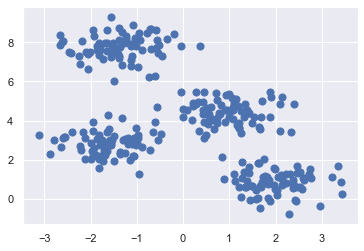

In [37]:
#generate data
from sklearn.datasets.samples_generator import make_blobs

x, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(x[:,0], x[:,1], s=50)


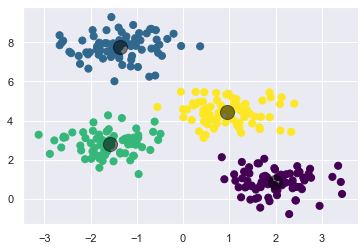

In [38]:
#do clustering

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(x)

y_pred = kmeans.predict(x)

#plot the results
plt.scatter(x[:,0], x[:,1], c=y_pred, s=50, cmap='viridis')

#plot the centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

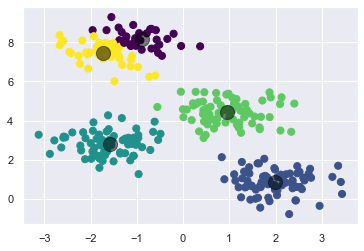

In [39]:
#what if the number of clusters is "accidentally" set larger or smaller?
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

y_pred = kmeans.predict(x)

#plot the results
plt.scatter(x[:,0], x[:,1], c=y_pred, s=50, cmap='viridis')

#plot the centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


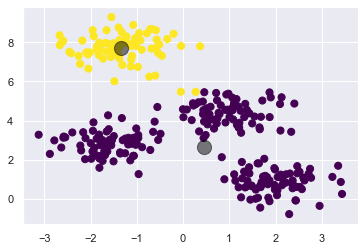

In [40]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

y_pred = kmeans.predict(x)

#plot the results
plt.scatter(x[:,0], x[:,1], c=y_pred, s=50, cmap='viridis')

#plot the centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

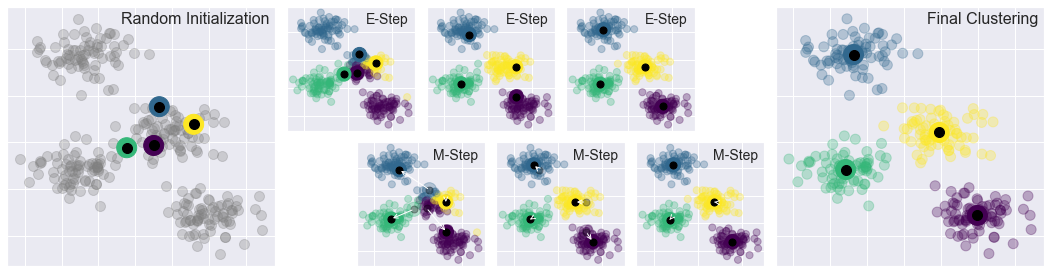

In [41]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('expectation-maximization.png')

### Note: K-means is limited to linear cluster boundaries

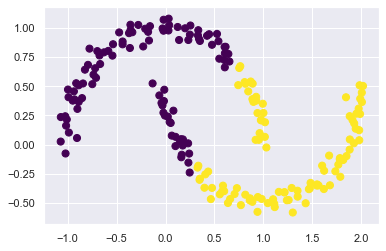

In [42]:
from sklearn.datasets import make_moons

x, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(n_clusters=2, random_state=0).fit_predict(x)

plt.scatter(x[:,0], x[:,1], c=labels, s=50, cmap='viridis')

/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


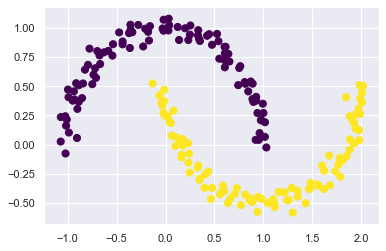

In [43]:
#kernelized kmeans
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels,
            s=50, cmap='viridis');

# Association mining with apriori algorithm

Library: `apyori`

Dataset: 7500 transactions
https://drive.google.com/file/d/1y5DYn0dGoSbC22xowBq2d4po6h1JxcTQ/view

--> data of one-week time period

In [44]:
df = pd.read_csv("store_data.csv", header=None)

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df.shape

(7501, 20)

In [47]:

records = df.values

In [48]:
records

array([['shrimp', 'almonds', 'avocado', ..., 'frozen smoothie',
        'spinach', 'olive oil'],
       ['burgers', 'meatballs', 'eggs', ..., nan, nan, nan],
       ['chutney', nan, nan, ..., nan, nan, nan],
       ...,
       ['chicken', nan, nan, ..., nan, nan, nan],
       ['escalope', 'green tea', nan, ..., nan, nan, nan],
       ['eggs', 'frozen smoothie', 'yogurt cake', ..., nan, nan, nan]],
      dtype=object)

In [49]:
with open("store_data.csv", 'r') as f:
    records = [line.strip().split(",") for line in f]
    

In [50]:
records[:5]

[['shrimp',
  'almonds',
  'avocado',
  'vegetables mix',
  'green grapes',
  'whole weat flour',
  'yams',
  'cottage cheese',
  'energy drink',
  'tomato juice',
  'low fat yogurt',
  'green tea',
  'honey',
  'salad',
  'mineral water',
  'salmon',
  'antioxydant juice',
  'frozen smoothie',
  'spinach',
  'olive oil'],
 ['burgers', 'meatballs', 'eggs'],
 ['chutney'],
 ['turkey', 'avocado'],
 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea']]

In [51]:
# we want rules for only those items that are purchased at least 5 times a day, or 7*5 = 35 times in one week
# --> support must >= 35/7500 = 0.0045

from apyori import apriori

association_rules = apriori(
                        records,
                        min_support=0.0045,
                        min_confidence=0.2,
                        min_lift=3,
                        min_length=2
)

#convert generator to list
association_rules = list(association_rules)

In [52]:
len(association_rules)

24

In [53]:
association_rules[:1]

[RelationRecord(items=frozenset({'light cream', 'chicken'}), support=0.004532728969470737, ordered_statistics=[OrderedStatistic(items_base=frozenset({'light cream'}), items_add=frozenset({'chicken'}), confidence=0.29059829059829057, lift=4.84395061728395)])]

In [54]:
# --> chicken is 4.84 times more likely to be bought by customers who buy light cream
# compared to the default likelihood of the sale of chicken

In [55]:
for item in association_rules:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: light cream -> chicken
Support: 0.004532728969470737
Confidence: 0.29059829059829057
Lift: 4.84395061728395
Rule: mushroom cream sauce -> escalope
Support: 0.005732568990801226
Confidence: 0.3006993006993007
Lift: 3.790832696715049
Rule: escalope -> pasta
Support: 0.005865884548726837
Confidence: 0.3728813559322034
Lift: 4.700811850163794
Rule: herb & pepper -> ground beef
Support: 0.015997866951073192
Confidence: 0.3234501347708895
Lift: 3.2919938411349285
Rule: tomato sauce -> ground beef
Support: 0.005332622317024397
Confidence: 0.3773584905660377
Lift: 3.840659481324083
Rule: olive oil -> whole wheat pasta
Support: 0.007998933475536596
Confidence: 0.2714932126696833
Lift: 4.122410097642296
Rule: pasta -> shrimp
Support: 0.005065991201173177
Confidence: 0.3220338983050847
Lift: 4.506672147735896
Rule: shrimp -> chocolate
Support: 0.005332622317024397
Confidence: 0.23255813953488375
Lift: 3.2545123221103784
Rule: cooking oil -> ground beef
Support: 0.004799360085321957
Confiden

# Decision Trees

- ID3
- C4.5
- C5
- CART


## C4.5

Reference: https://github.com/barisesmer/C4.5

In [194]:
from c45 import C45

clf = C45("iris.data", 'iris.names') #path to data file and path to description file
clf.fetchData()
clf.preprocessData()
clf.generateTree()
clf.printTree()

petal width <= 0.8 : Iris-setosa
petal width > 0.8 : 
	petal length <= 4.75 : 
		sepal length <= 4.95 : 
			sepal width <= 2.45 : Iris-versicolor
			sepal width > 2.45 : Iris-virginica
		sepal length > 4.95 : Iris-versicolor
	petal length > 4.75 : 
		sepal length <= 7.0 : 
			sepal width <= 3.25 : Iris-virginica
			sepal width > 3.25 : Iris-virginica
		sepal length > 7.0 : Iris-virginica


[Text(167.4, 199.32, 'X[2] <= 2.45\nentropy = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(141.64615384615385, 163.07999999999998, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(193.15384615384616, 163.07999999999998, 'X[3] <= 1.75\nentropy = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(103.01538461538462, 126.83999999999999, 'X[2] <= 4.95\nentropy = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(51.50769230769231, 90.6, 'X[3] <= 1.65\nentropy = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(25.753846153846155, 54.359999999999985, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(77.26153846153846, 54.359999999999985, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(154.52307692307693, 90.6, 'X[3] <= 1.55\nentropy = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(128.76923076923077, 54.359999999999985, 'entropy = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(180.27692307692308, 54.359999999999985, 'X[2] <= 5.45\nentropy = 0.444\nsamples = 3\nvalue

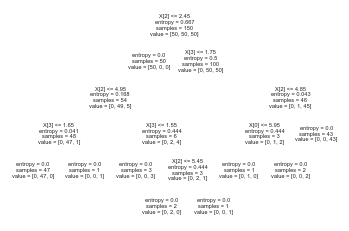

In [196]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

tree.plot_tree(clf)

# Regression

multiple linear regression

data: https://drive.google.com/file/d/1mVmGNx6cbfvRHC_DvF12ZL3wGLSHD9f_/view

Predict the gas consumptions (in millions of gallons) in 48 US states based upon gas taxes (in cents), per capita income (dollars), paved highways (in miles) and the proportion of population that has a drivers license.

In [56]:
import pandas as pd

In [57]:
dataset = pd.read_csv("petrol_consumption.csv")
dataset.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [58]:
dataset.describe()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.668333,4241.833333,5565.416667,0.570333,576.770833
std,0.950770,573.623768,3491.507166,0.055470,111.885816
min,5.000000,3063.000000,431.000000,0.451000,344.000000
25%,7.000000,3739.000000,3110.250000,0.529750,509.500000
50%,7.500000,4298.000000,4735.500000,0.564500,568.500000
75%,8.125000,4578.750000,7156.000000,0.595250,632.750000
max,10.000000,5342.000000,17782.000000,0.724000,968.000000


In [59]:
x = dataset[['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)']]
y = dataset['Petrol_Consumption']

In [60]:
# make train and test sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2,
        random_state=0
)

#NOTE: won't use validation set for training --> don't need to create


In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
coeff_df = pd.DataFrame(model.coef_, x.columns, columns=['Coefficients'])
coeff_df

,Coefficients
Petrol_tax,-40.016660
Average_income,-0.065413
Paved_Highways,-0.004741
Population_Driver_licence(%),1341.862121


In [63]:
# This means that for a unit increase in "petrol_tax",
# there is a decrease of 24.19 million gallons in gas consumption.
# Similarly, a unit increase in proportion of population with a drivers license
# results in an increase of 1.324 billion gallons of gas consumption.
# We can see that "Average_income" and "Paved_Highways" have a very little effect on the gas consumption.

In [64]:
# test the model on test set
y_pred = model.predict(x_test)


In [65]:
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

,Actual,Predicted
29,534,469.391989
4,410,545.645464
26,577,589.668394
30,571,569.730413
32,577,649.774809
37,704,646.631164
34,487,511.608148
40,587,672.475177
7,467,502.074782
10,580,501.270734


In [66]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 56.8222474789647
Mean Squared Error: 4666.344787588363
Root Mean Squared Error: 68.3106491521517


## Cross validation

In [67]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()

cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error')


array([ -7152.70365453,  -1149.50731332,  -3740.57862225,  -6034.31653965,
        -3693.28413168,  -1845.31367627,  -2222.53162671, -15418.77235485,
        -3331.19035052,  -3057.61758362])

# Wine quality prediction

In [68]:
#load data
df = pd.read_csv("winequality-white.csv", delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [69]:
#number of data
df.shape

(4898, 12)

In [70]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

#get data 
x = df[features]
y = df['quality']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25,
    random_state=3
)


In [71]:
#using SVM for regression
from sklearn import svm

reg = svm.SVR(kernel='linear')
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)

from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5901819397557855
Mean Squared Error: 0.5848652102415209
Root Mean Squared Error: 0.764764807141072


In [72]:
#using different kernel
reg = svm.SVR(kernel='rbf', epsilon=0.001)
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Absolute Error: 0.5362726766674536
Mean Squared Error: 0.5917358500735836
Root Mean Squared Error: 0.7692436870547483


In [73]:
#using Linear regression
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5872488344616063
Mean Squared Error: 0.5724022232298807
Root Mean Squared Error: 0.756572682053668


In [74]:
#using feature scaling
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

reg = svm.SVR(kernel='rbf', epsilon=0.001)
reg.fit(x_train_scaled, y_train)

y_pred = reg.predict(x_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5268196899494411
Mean Squared Error: 0.499542604664772
Root Mean Squared Error: 0.7067832798423941


# Wine classification

Dataset: https://archive.ics.uci.edu/ml/datasets/wine

- 178 data instances
- 13 attributes/features
- 3 classes


In [75]:
from sklearn.datasets import load_wine
x, y = load_wine(return_X_y=True)

print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (178, 13)
y shape:  (178,)


In [76]:
# inspect the samples per class
from collections import Counter

Counter(y)

Counter({0: 59, 1: 71, 2: 48})

In [77]:
#make train, test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=42
)

In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score

model = svm.SVC()

#train model
model.fit(x_train, y_train)

/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [79]:
#predict test set
y_pred = model.predict(x_test)

# calculate accuracy score
score = accuracy_score(y_test, y_pred)
print("accuracy: ", score)

accuracy:  0.42592592592592593


In [80]:
#investigate the data
import pandas as pd

df = pd.DataFrame(
        data=x_train, #values
        columns=['alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium',
                 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'proanthocyanins',
                 'color intensity', 'hue', 'OD280/OD315', 'proline'
                ]
)

In [81]:
df.head()

,alcohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD280/OD315,proline
0,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0
1,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0
2,12.33,0.99,1.95,14.8,136.0,1.90,1.85,0.35,2.76,3.40,1.06,2.31,750.0
3,13.28,1.64,2.84,15.5,110.0,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880.0
4,12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.15,1.15,3.30,290.0


### Feature scaling

In [82]:
# importance of feature scaling
# scale so that all features are centered around zero and have variance in the same order
# standard normally distributed data: Gaussian with zero mean and unit variance
from sklearn import preprocessing

x_scaled = preprocessing.scale(x_train)
pd.DataFrame(data=x_scaled, columns=df.columns).head()

,alcohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD280/OD315,proline
0,0.628447,1.081206,-0.652127,0.000000,-0.841477,-1.003358,-1.517062,1.711448,-1.230771,0.333174,-0.641378,-1.070901,-0.518219
1,-0.540882,-0.612994,-1.427534,0.288180,-1.037487,-0.112585,-0.086751,-0.350476,-0.195036,-0.933495,0.346530,1.330768,-0.215063
2,-0.755657,-1.287031,-1.538306,-1.354445,2.294697,-0.573329,-0.156280,-0.112562,2.014532,-0.722384,0.432435,-0.398434,0.041960
3,0.377877,-0.694972,1.747940,-1.152719,0.595936,0.501741,0.668135,-0.191866,-0.402183,-0.171658,0.561293,0.246586,0.470333
4,-0.803385,0.388952,-0.541355,-0.432270,-0.841477,0.271369,0.241029,-0.905609,0.685339,-1.296056,0.819008,0.960225,-1.473819


In [83]:
x_scaled.mean(axis=0)

array([ 2.55440830e-15, -7.03906019e-16,  2.92642255e-15, -2.46218816e-17,
        1.93617523e-16,  1.19528043e-15,  1.77949053e-17, -9.02056208e-16,
        6.80906944e-16,  9.92037993e-16,  2.35116586e-15,  1.51491722e-15,
        6.35692216e-17])

In [84]:
x_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [85]:
#build scaler
scaler = preprocessing.StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = svm.SVC()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

score = accuracy_score(y_test, y_pred)
print("Accuracy on scaled data: ", score)

Accuracy on scaled data:  0.9814814814814815


## Naive Bayes classification



In [86]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

#fit model
model.fit(x_train_scaled, y_train)
#predict
y_pred = model.predict(x_test_scaled)
#evaluate
score = accuracy_score(y_test, y_pred)
print("Accuracy on scaled data: ", score)

Accuracy on scaled data:  1.0


In [87]:
# what if learning from unscaled data

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
#evaluate
score = accuracy_score(y_test, y_pred)
print("Accuracy on scaled data: ", score)

Accuracy on scaled data:  1.0


## Logistis regression

In [88]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
#evaluate
score = accuracy_score(y_test, y_pred)
print("Accuracy on scaled data: ", score)

Accuracy on scaled data:  1.0


/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
